# Итоговое задание по Проекту 5. Выбираем авто выгодно
***
### Импорт библиотек

In [1]:
import numpy as np 
import pandas as pd
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import collections
%matplotlib inline

from sklearn.feature_selection import f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
import os

In [2]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('25/11/2020')

Зададим необходимые функции сразу

In [3]:
def IQRhist(col):
    dft = (df.loc[df['Train'] == 1][col])
    median = dft.median()
    perc25 = dft.quantile(0.25)
    perc75 = dft.quantile(0.75)
    IQR = perc75 - perc25
    print('25-й перцентиль: {},'.format(round(perc25,4)), '75-й перцентиль: {},'.format(round(perc75,4)),
          "IQR: {}, ".format(round(IQR,4)), "Границы выбросов: [{f}, {l}].".format(f=round(perc25 - 1.5*IQR,4), l=round(perc75 + 1.5*IQR,4)))
    out_count = dft.apply(
        lambda x: None if x < perc25 - 1.5*IQR or x > perc75 + 1.5*IQR else x).isna().sum()
    print(f'Кол-во выбросов = {out_count}, Процент выбросов среди тренировочного датасета {round((out_count/len(dft)*100),2)}')
    df[col].loc[df[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins=10, range=(dft.min()-5, dft.max()+5),
                                                                          label='IQR')

    plt.legend()

In [4]:
print(os.listdir('./'))

['.ipynb_checkpoints', 'all_car_brands_and_their_models_from_auto_ru.csv', 'baseline-sf-dst-car-price-prediction-v14.ipynb', 'Car Price prediction-Copy1.ipynb', 'Car Price prediction-Copy2.ipynb', 'Car Price prediction.ipynb', 'catboost_info', 'requirements.txt', 'sample_submission.csv', 'test.csv', 'train.csv', 'Untitled.ipynb', 'Untitled1.ipynb', 'Untitled2.ipynb']


### Импорт данных

In [5]:
from importlib import reload
print(os.listdir('./'))
DIR_TRAIN  = '../' # подключил к ноутбуку свой внешний датасет
DIR_TEST   = '../'

['.ipynb_checkpoints', 'all_car_brands_and_their_models_from_auto_ru.csv', 'baseline-sf-dst-car-price-prediction-v14.ipynb', 'Car Price prediction-Copy1.ipynb', 'Car Price prediction-Copy2.ipynb', 'Car Price prediction.ipynb', 'catboost_info', 'requirements.txt', 'sample_submission.csv', 'test.csv', 'train.csv', 'Untitled.ipynb', 'Untitled1.ipynb', 'Untitled2.ipynb']


In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('sample_submission.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(2))
print('Размерность тестового датасета: ', test.shape)
display(test.head(2))
print('Размерность датасета c примером сабмишена: ', submit.shape)
display(submit.head(2))

Размерность тренировочного датасета:  (89378, 26)


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,2.8,174.0,"Машина в приличном состоянии ,не гнилая не р...",350000,{'id': '0'},полный,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,Машина в оригинале не гнилая все вопросы по те...,173424,{'id': '0'},передний,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100


Размерность тестового датасета:  (3837, 23)


,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,id
0,седан,BMW,чёрный,дизель,2016.0,520d 2.0d AT (190 л.с.),4.0,2017.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,190 N12,В РОЛЬФ Ясенево представлено более 500 автомоб...,158836.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,0
1,седан,BMW,белый,дизель,2018.0,318d 2.0d AT (150 л.с.),4.0,2019.0,SEDAN AUTOMATIC 2.0,автоматическая,2.0 LTR,150 N12,Автомобиль из демонстрационного парка по спец ...,10.0,"['[{""name"":""Комфорт"",""values"":[""Круиз-контроль...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,Растаможен,NaN,1


Размерность датасета c примером сабмишена:  (3837, 2)


,id,price
0,0,5299000.0
1,1,1580000.0


### Первичная обработка датасетов

In [7]:
# Для удобства зададим функцию, которая создаст отдельный датафрейм с этими признаками для сравнения
def check_df(df1,df2):
    '''
    Функция создает отдельный датафрейм с признаками: название,количество уникальных значений, их тип, содержание.
    А так же показывает несоответствие признаков
    '''
    ## Соберем данные по первому датасету
    list_tags_1 = list(df1.columns)
    temp_dict = {}
    temp_dict['Уникальность_1'] = df1.nunique().values
    temp_dict['Первая_строка_1'] =df1.loc[0].values
    temp_dict['тип_1'] = df1.dtypes
    temp_dict['Признак_1'] = list_tags_1
    temp_df1 = pd.DataFrame.from_dict(temp_dict)
    
    ## Соберем данные по второму датасету
    list_tags_2 = list(df2.columns)
    temp_dict2 = {}
    temp_dict2['Признак_2'] = list_tags_2
    temp_dict2['тип_2'] = df2.dtypes
    temp_dict2['Первая_строка_2'] =df2.loc[0].values
    temp_dict2['Уникальность_2'] = df2.nunique().values
    temp_df2 = pd.DataFrame.from_dict(temp_dict2)
    
    ##объеденим датасеты
    temp_df = pd.concat([temp_df1,temp_df2], axis=1, sort=False)
    temp_df.reset_index(inplace = True)
    del temp_df['index']
    display(temp_df)
    
    ## Создадим словари для сравнения данных
    temp_dict3 = {}
    temp_df3= pd.DataFrame(temp_df)
    temp_list  = []
    temp_list2  = []
    temp_list3  = []
    temp_list4  = []
    temp_list5  = []

    for i in range(len(temp_df)):
        if str(temp_df3['тип_2'][i]) != str(temp_df3['тип_1'][i]):
            temp_list.append(temp_df3['Признак_1'][i])
            temp_list2.append(temp_df3['Признак_2'][i])
            temp_list3.append(str(temp_df3['тип_1'][i]) + ' != ' + str(temp_df3['тип_2'][i]))
            temp_list4.append(i)
        
    ## Создаем сравнительный датасет
    temp_dict3['index']= temp_list4
    temp_dict3['Признак_1']= temp_list
    temp_dict3['Отличие'] = temp_list3
    temp_dict3['Признак_2']= temp_list2

    temp_df4 = pd.DataFrame.from_dict(temp_dict3)
    temp_df4.set_index('index',inplace=True)

    print(f'Вывод:\n 1. Не совпали типы в {len(temp_df4)} столбцах:')
    display(temp_df4)

    return

#### Для начала сравним датасеты 

Рассмотрим каждую колонку:  
    - её название,
    - количество уникальных значений,
    - её тип,  
    - её содержание.
И проверим их различие

In [8]:
check_df(train, test)

,Уникальность_1,Первая_строка_1,тип_1,Признак_1,Признак_2,тип_2,Первая_строка_2,Уникальность_2
0,168.0,Седан,object,bodyType,bodyType,object,седан,11.0
1,36.0,AUDI,object,brand,brand,object,BMW,1.0
2,16.0,040001,object,color,color,object,чёрный,15.0
3,6.0,бензин,object,fuelType,fuelType,object,дизель,4.0
4,78.0,1990,float64,modelDate,modelDate,float64,2016,31.0
5,4484.0,2.8 MT (174 л.с.) 4WD,object,name,name,object,520d 2.0d AT (190 л.с.),384.0
6,5.0,4,float64,numberOfDoors,numberOfDoors,float64,4,4.0
7,80.0,1991,int64,productionDate,productionDate,float64,2017,37.0
8,1860.0,SEDAN MECHANICAL 2.8,object,vehicleConfiguration,vehicleConfiguration,object,SEDAN AUTOMATIC 2.0,99.0
9,4.0,MECHANICAL,object,vehicleTransmission,vehicleTransmission,object,автоматическая,3.0


Вывод:
 1. Не совпали типы в 11 столбцах:


,Признак_1,Отличие,Признак_2
index,,,
7,productionDate,int64 != float64,productionDate
11,enginePower,float64 != object,enginePower
13,mileage,int64 != float64,mileage
17,Состояние,float64 != object,Состояние
18,Владельцы,float64 != object,Владельцы
20,Таможня,bool != object,Таможня
22,price,float64 != nan,NaN
23,start_date,object != nan,NaN
24,hidden,float64 != nan,NaN


##### Промежуточный итог: 
Видно что в 6 столбцах различаются типы значений,  
4 столбцов нет в тестовом датасете и 1 в тренировочном.  

1.Приведем столбцы типа int64 к float64, поскольку мы еще подробно не исследовали датасет,  
и не знаем какие значения могут принимать параметры.  

2.Так же для столбцов с отличиями: float64 != object, bool != object  
изменим тип на object.  

In [9]:
#1
change_type = ['productionDate', 'mileage']
for col in change_type:
        train[col] = train[col].astype('float64')

In [10]:
#2
change_type = ['enginePower', 'Состояние', 'Владельцы']
for col in change_type:
        train[col] = train[col].astype('object')

In [11]:
#Типом bool оказался признак Таможня, он принмает значения True/False,  
#в тестовом он задан как Растаможен/Не растаможен
#Пока что приведем данный признак к значеним тестового датасета
#train['Таможня'] = train['Таможня'].map({True: 'Растаможен', False:'Не растаможен'})
train['Таможня'].value_counts()

True    89378
Name: Таможня, dtype: int64

### Итог:  
---
Как уже было сказано 4 столбцов нет в тестовом датасете и 1 в тренировочном.  

В тестовом нет целевой переменной, поскольку ее требуется определить.
А так же отсутствуют признаки start_date, hidden, model.  
Пока что оставим их и попробуем добавить их в тестовый датасет. 

В тренировочном отсутствует столбцец id, который нам будет нужен для формирования файла submition.

### Обработка данных перед слиянием

Признак bodyType отличается регистром в обоих датасетах
Приведем тренировочный датасет к нижнему регистру

In [12]:
train['bodyType'] = train['bodyType'].apply(lambda x: str(x).lower())
train['bodyType'].value_counts()[:5]

внедорожник 5 дв.    31885
седан                30593
хэтчбек 5 дв.         8668
универсал 5 дв.       3385
лифтбек               3121
Name: bodyType, dtype: int64

In [13]:
train['color'].value_counts()

040001    25212
FAFBFB    15824
CACECB    11336
97948F    10819
0000CC     8874
EE1D19     4508
200204     3583
007F00     2598
C49648     1854
22A0F8     1398
DEA522      774
660099      750
FFD600      701
4A2197      606
FF8649      516
FFC0CB       25
Name: color, dtype: int64

Признак color в тренировочном датасете указан в шестнадцатеричном коде цветов.  
Но их всего 16 поэтому приведм коды к значениям цветов.

In [14]:
test['color'].value_counts()[:5]

чёрный        1395
белый          767
синий          510
серый          453
коричневый     216
Name: color, dtype: int64

In [15]:
dict_color = {'040001':'чёрный', 'EE1D19':'красный', '0000CC':'синий', 
              'CACECB':'серебристый', '007F00':'зелёный', 'FAFBFB':'белый', 
              '97948F':'серый', '22A0F8':'голубой', '660099':'пурпурный', 
              '200204':'коричневый', 'C49648':'бежевый', 'DEA522':'золотистый', 
              '4A2197':'фиолетовый', 'FFD600':'жёлтый', 'FF8649':'оранжевый', 
              'FFC0CB':'розовый'}
train['color'] = train['color'].map(dict_color)

In [16]:
train['color'].value_counts()[:5]

чёрный         25212
белый          15824
серебристый    11336
серый          10819
синий           8874
Name: color, dtype: int64

In [17]:
test['vehicleTransmission'].value_counts()

автоматическая      3677
механическая         111
роботизированная      49
Name: vehicleTransmission, dtype: int64

Признак vehicleTransmission - тип трасмиссии, приведем к виду тестового датасета

In [18]:
train['vehicleTransmission'] = train['vehicleTransmission'].map(
    {'MECHANICAL': 'механическая', 'AUTOMATIC': 'автоматическая', 'ROBOT': 'роботизированная', 'VARIATOR': 'вариатор'})
train['vehicleTransmission'].value_counts()

автоматическая      49218
механическая        25264
роботизированная     7871
вариатор             7024
Name: vehicleTransmission, dtype: int64

Признак руль приведем к виду тестового датасета

In [19]:
train['Руль'] = train['Руль'].map({'RIGHT':'Правый', 'LEFT':'Левый'})
train['Руль'].value_counts()

Левый     87589
Правый     1789
Name: Руль, dtype: int64

Признак ПТС приведем к виду тестового датасета

In [20]:
train['ПТС'] = train['ПТС'].map({'ORIGINAL':'Оригинал', 'DUPLICATE':'Дубликат'})
train['ПТС'].value_counts()

Оригинал    78597
Дубликат    10420
Name: ПТС, dtype: int64

In [21]:
display(train['Владельцы'].value_counts())
display(test['Владельцы'].value_counts())

3.0    36248
2.0    21006
1.0    18536
Name: Владельцы, dtype: int64

3 или более    1516
1 владелец     1309
2 владельца    1012
Name: Владельцы, dtype: int64

Признак Владельцы приведем к виду тестового датасета

In [22]:
train['Владельцы'] = train['Владельцы'].map({3.0:'3 или более', 2.0:'2 владельца', 1.0:'1 владелец'})
display(train['Владельцы'].value_counts())

3 или более    36248
2 владельца    21006
1 владелец     18536
Name: Владельцы, dtype: int64

In [23]:
display(train['Владение'].value_counts()[:5])
display(test['Владение'].value_counts()[:5])

{'year': 2018, 'month': 10}    497
{'year': 2019, 'month': 8}     494
{'year': 2018, 'month': 8}     492
{'year': 2018, 'month': 9}     478
{'year': 2018, 'month': 11}    473
Name: Владение, dtype: int64

1 год и 1 месяц      40
1 год и 4 месяца     39
1 год и 3 месяца     37
1 год и 2 месяца     36
1 год и 8 месяцев    33
Name: Владение, dtype: int64

Признак Владение - в таблице сверху в первых строках Nan поэтому нужно отдельно проверить,  
Данные записаны в различном формате в разных датасетах, оставим до этапа анализа

### Итог  
Несоответсвие  осталось только в одном столбце - Владение, вернемся к данному признаку позже в детальном анализе

### Слияние датасетов в один

In [24]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['Train'] = 1 # помечаем где у нас трейн
test['Train'] = 0 # помечаем где у нас тест

df = train.append(test, sort=False).reset_index(drop=True) # объединяем

In [25]:
# проверка  после слияния
df.head(2)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model,Train,id
0,седан,AUDI,чёрный,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991.0,SEDAN MECHANICAL 2.8,механическая,2.8,174,"Машина в приличном состоянии ,не гнилая не р...",350000.0,{'id': '0'},полный,Левый,NaN,3 или более,Оригинал,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100,1,NaN
1,седан,AUDI,красный,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986.0,SEDAN MECHANICAL 1.8,механическая,1.8,90,Машина в оригинале не гнилая все вопросы по те...,173424.0,{'id': '0'},передний,Левый,NaN,3 или более,Оригинал,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100,1,NaN


### Предварительный анализ данных

In [26]:
def describe_cols(df):
    list_ = list(df.columns)
    temp_dict = {}
    temp_dict['Признак'] = list_
    temp_dict['Тип'] = df.dtypes
    temp_dict['Кол-во значений'] = df.describe(include='all').loc['count']
    temp_dict['Кол-во пропусков(NaN)'] = df.isnull().sum().values 
    temp_dict['Кол-во уникальных'] = df.nunique().values
    temp_df = pd.DataFrame.from_dict(temp_dict, orient='index')
    display(temp_df.T)

    return

In [27]:
describe_cols(df[df['Train']==1])

,Признак,Тип,Кол-во значений,Кол-во пропусков(NaN),Кол-во уникальных
0,bodyType,object,89378,0,168
1,brand,object,89378,0,36
2,color,object,89378,0,16
3,fuelType,object,89378,0,6
4,modelDate,float64,89377,1,78
5,name,object,89377,1,4484
6,numberOfDoors,float64,89377,1,5
7,productionDate,float64,89378,0,80
8,vehicleConfiguration,object,89377,1,1860
9,vehicleTransmission,object,89377,1,4


In [28]:
describe_cols(df[df['Train']==0])

,Признак,Тип,Кол-во значений,Кол-во пропусков(NaN),Кол-во уникальных
0,bodyType,object,3837,0,11
1,brand,object,3837,0,1
2,color,object,3837,0,15
3,fuelType,object,3837,0,4
4,modelDate,float64,3837,0,31
5,name,object,3837,0,384
6,numberOfDoors,float64,3837,0,4
7,productionDate,float64,3837,0,37
8,vehicleConfiguration,object,3837,0,99
9,vehicleTransmission,object,3837,0,3


### ИТОГ  
---
В тренировочной выборке 88968 строк, в тестовой 3837. Всего данных - 93215 строк.  
Всего 28 признаков, из них:   
В тестовом - 23, из них:  
4 - числовых - mileage, modelDate, productionDate, id (для генерации submition),  
19 - категориальных (возможно часть из них станен числовыми при полном анализе),  

4 признака были добавлены от тренировочного:  
1- числовой - price, 1 - временной ряд - start_date,  
1 - бинарный - hidden, 1 -   категориальный - model  
и 1 - бинарный Train - для разделения train и test

### Описания полей датасета  

- bodyType - тип кузова автомобиля  
- brand - марка (бренд) автомобиля  
- color - цвет автомобиля  
- fuelType - тип топлива 
- modelDate - дата выпуска модели 
- name - комбинация нескольких характеристик (модели, объема двигателя и привода)  
- numberOfDoors - кол-во дверей  
- productionDate - дата производства авто  
- vehicleConfiguration - комбинация типа трансмиссии, объема двигателя и мощности двигателя  
- vehicleTransmission - тип трансмиссии (коробки передач) 
- engineDisplacement - объем двигателя в литрах  
- enginePower - мощность двигателя (л.с.)  
- description - дополнительные характеристики по комплектации авто  
- mileage - пробег автомобиля (км.) 
- Комплектация - дополнительные характеристики по комплектации авто  
- Привод - характеристика привода автомобиля, которое передает энергию от двигателя на колеса.  
- Руль - характеристика руля по стороне расположения руля в автомобиле  
- Состояние - характеристика необходимости проведения ремонта  
- Владельцы - кол-во владельцев (3 значения: 1 владелец, 2 владельца, 3 и более)  
- ПТС - тип ПТС (паспорт технического средства)  
- Таможня - информация о том расстаможен автомобиль или нет (2 значения - Растаможен, Не ратаможен)   
- Владение - срок владения автомобилем в годах и месяцах  
- price - цена указанная в объявлении на авто.ру  
- start_date - дата размещения объявления на авто.ру  
- hidden - характеристика объявления на авто.ру  
- model - название модели автомобиля   
- Train - сервисный для разделения train и test   
- id - - сервисный для генерации submition  

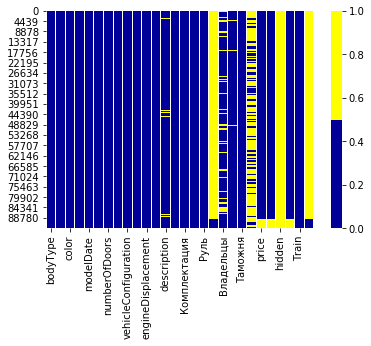

In [29]:
cols = df.columns 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

#### Детальная информация по пропускам датасета раздельно:  
----
В тренировочном датасете признаки:  
modelDate name, object, numberOfDoors, vehicleConfiguration,  
vehicleTransmission, engineDisplacement, enginePower, Привод  
имеют 1 пропуск (можно удалить, влияние 1 значение на такой выборки не имеет).  
В description 3254 (>3%) пропуска, попробуем заполнить.   
(много но не критично можно попробовать удалить и посмотреть разницу).  
Состояние - 89378 (100.0%) -  важный признак, нужно постараться заполнить аналогичным  
по критериям авто требующих ремонта - так как этот признак одназначно влияет на цену.  
Владельцы - 13588 (>15%) , попробуем заполнить.  
Владение - 60177 (>67%) - тоже важный признак, но очень много пропусков, надо попробовать заполнить  
hidden - 89378 (100.0%) => надо удалить.  
id - 89378 (100.0%) - это столбец для генерации файла submition(ничего не делаем)
 
В тестовом датасете признаки:  
Владение - 2084 (>54%) - надо попробовать заполнить  
(но пропусках много в обоих датасетах, пока что кажется разумным удалить этот признак).  
price 3837 (100.0%)- целевая переменная(ничего не делаем).  
start_date, hidden, model - 3837 (100.0%) - созданые тренировочным датасетом,  
надо проанализировать или использовать для создания новых признаков, или удалить.

Предварительно оценим скоррелированность числовых признаков

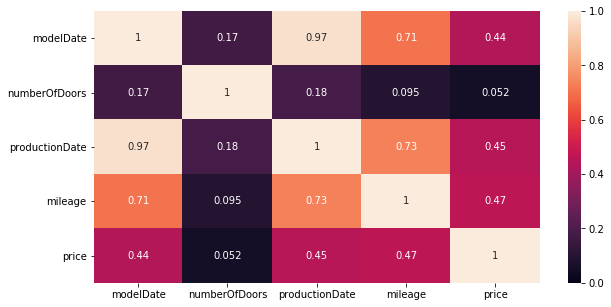

In [30]:
plt.figure(figsize=(10,5))
sns.heatmap(df[['modelDate','numberOfDoors','productionDate','mileage', 'price']].corr().abs(), vmin=0, vmax=1, annot=True)

Между productionDate и modelDate  слишком выская корреляция, есть смысл удалить productionDate и оставить только modelDate,    
пока оставляем посмотрим на общую корреляцию после изменения типов переменных.

признак Таможня бесполезен так как содержит одно значение - Растаможен удаляем 
brand - только одно значение - "BMW"   
Руль - только одно значение - "Левый" надо взять из трейна только авто с Левым рулем!   
Состояние - только одно значение - "Не требует ремонта" после заолнение этого признака в тренировочном датасете надо взять из трейна только авто не требующие ремонта(посмотрим на выбросы по ценам)

#### Внесем данные по типам переменных в списки 

In [33]:
# временной ряд (1)
time_cols = ['start_date']
# бинарная переменная ()
bin_cols = []
# категориальные переменные(19)
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'name',
       'numberOfDoors', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Владение', 'model']
# числовые переменные (3) 
num_cols = ['mileage', 'modelDate', 'productionDate']
# сервисные переменные (2)
servis_cols = ['Train', 'id']
# целевая переменная (1)
target_col = ['price']
all_cols =cat_cols+num_cols+time_cols+servis_cols+bin_cols+ target_col
print(f'Кол-во столбцов, для дальнейшей работы после предварительного анализа:= {len(all_cols)}')

Кол-во столбцов, для дальнейшей работы после предварительного анализа:= 26


#### Реализуем выводы перед детальным анализом по переменным

In [34]:
#Сохраним купию датасета на всякий случай
df_copy = df.copy()
#Оставим только машины с левы рулем в состоянии Не требует ремонта
df = df.loc[df['Руль'] == 'Левый', all_cols]
# исключаем Руль из списка признаков для анализа итого остается 25 признаков из которых 2 сервисных (нужно проанализировать 23=25-2)
cat_cols.remove('Руль')

# удаляем дубликаты
df = df.drop_duplicates()
old_len_train = len(df[df['Train']==1])
print('Кол-во строк в трейне: ', old_len_train)

Кол-во строк в трейне:  85481


### Детальный анализ по переменным
---

Поскольку признаков много создадим список в который будем записывать проанализированные параметры

In [35]:
EDA_cols=[]

#### 1. bodyType
#### Тип кузова автомобиля

In [36]:
df_Train = df[df['Train']==1]
df_Test = df[df['Train']==0]
print(f'Всего в тесте типов кузова: {df_Test.bodyType.nunique()}')
print(f'Всего в трейне типов кузова: {df_Train.bodyType.nunique()}')

Всего в тесте типов кузова: 11
Всего в трейне типов кузова: 144


In [37]:
# посмотрим на них 
print(f'Список 11 типов кузова из теста: \n{df_Test.bodyType.unique()}')
print(f'Список первых 20 из 144 типов кузова из трейна: \n {df_Train.bodyType.unique()[:20]}')

Список 11 типов кузова из теста: 
['седан' 'внедорожник 5 дв.' 'хэтчбек 3 дв.' 'хэтчбек 5 дв.' 'купе'
 'родстер' 'лифтбек' 'универсал 5 дв.' 'кабриолет' 'седан 2 дв.'
 'компактвэн']
Список первых 20 из 144 типов кузова из трейна: 
 ['седан' 'универсал 5 дв.' 'хэтчбек 5 дв. sportback' 'хэтчбек 3 дв.'
 'хэтчбек 5 дв.' 'кабриолет' 'купе' 'лифтбек sportback' 'лифтбек'
 'седан long' 'внедорожник 5 дв.' 'кабриолет roadster' 'седан 2 дв.'
 'седан gran coupe' 'компактвэн' 'компактвэн gran tourer'
 'лифтбек gran turismo' 'хэтчбек 3 дв. compact' 'лифтбек gran coupe'
 'купе-хардтоп']


In [38]:
# оставляем только типы кузова как в тесте
list_bodyType_test = list(df_Test.bodyType.unique())
df = df[df['bodyType'].isin(list_bodyType_test)]

In [39]:
df_Train = df[df['Train']==1]
print(f'Кол-во строк в трейне: {len(df_Train)}')

Кол-во строк в трейне: 79193


In [40]:
df['bodyType'].value_counts()

внедорожник 5 дв.    32183
седан                31103
хэтчбек 5 дв.         8535
универсал 5 дв.       3218
лифтбек               3131
компактвэн            1728
купе                  1420
хэтчбек 3 дв.         1373
кабриолет              173
родстер                157
седан 2 дв.              9
Name: bodyType, dtype: int64

#### bodyType 
Тип кузова
Категориальный признак, оставили только типы кузова из тестового сета(79193), пропусков нет.

In [41]:
EDA_cols.append('bodyType')

In [42]:
df.head(2)

,bodyType,brand,color,fuelType,name,numberOfDoors,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Владение,model,mileage,modelDate,productionDate,start_date,Train,id,price
0,седан,AUDI,чёрный,бензин,2.8 MT (174 л.с.) 4WD,4.0,SEDAN MECHANICAL 2.8,механическая,2.8,174,"Машина в приличном состоянии ,не гнилая не р...",{'id': '0'},полный,Левый,NaN,3 или более,Оригинал,NaN,100,350000.0,1990.0,1991.0,2019-10-03T08:09:11Z,1,NaN,200000.0
1,седан,AUDI,красный,бензин,1.8 MT (90 л.с.),4.0,SEDAN MECHANICAL 1.8,механическая,1.8,90,Машина в оригинале не гнилая все вопросы по те...,{'id': '0'},передний,Левый,NaN,3 или более,Оригинал,NaN,100,173424.0,1982.0,1986.0,2020-09-06T06:49:40Z,1,NaN,60000.0


#### 2. brand
#### Марка (бренд) автомобиля

In [43]:
print(f'Всего в датасета марок: {df.brand.nunique()}')
print(f'Марки: \n {df.brand.value_counts()[:20]}')

Всего в датасета марок: 36
Марки: 
 BMW           10346
MERCEDES       6537
VOLKSWAGEN     6093
KIA            5320
HYUNDAI        5209
NISSAN         5157
FORD           4498
TOYOTA         3697
AUDI           3531
CHEVROLET      3511
MITSUBISHI     3265
OPEL           2768
SKODA          2712
RENAULT        2478
MAZDA          2158
VOLVO          2038
PEUGEOT        1577
LAND_ROVER     1530
INFINITI       1024
DAEWOO         1007
Name: brand, dtype: int64


In [44]:
old_len_train1 = len(df[df['Train']==1])
print('Кол-во строк в трейне:= ', old_len_train1)

Кол-во строк в трейне:=  79193


#### brand
Категориальный признак, все марки машин пока, что оставляем как есть, пропусков нет

In [45]:
EDA_cols.append('brand')

#### 3. color
#### Цвет автомобиля

In [46]:
df['color'].value_counts()

чёрный         23470
белый          14532
серебристый    10301
серый          10122
синий           8451
красный         4214
коричневый      3514
зелёный         2293
бежевый         1743
голубой         1310
золотистый       736
пурпурный        679
жёлтый           602
фиолетовый       548
оранжевый        497
розовый           18
Name: color, dtype: int64

In [47]:
df[df['Train']==1].groupby(['color'])['price'].median().sort_values(ascending=False)
#max()

color
коричневый     970000.0
белый          870000.0
оранжевый      810000.0
чёрный         780000.0
серый          620000.0
синий          498000.0
бежевый        490000.0
фиолетовый     430000.0
серебристый    430000.0
жёлтый         405000.0
красный        400000.0
голубой        385000.0
розовый        367500.0
пурпурный      365000.0
золотистый     360000.0
зелёный        270000.0
Name: price, dtype: float64

#### color
категориальный признак, 16 значений, пропусков нет

In [48]:
EDA_cols.append('color')

#### 4. fuelType
#### Тип топлива(5 видов топлива: бензин, дизель, электро, гибрид, газ)

In [49]:
df_Train = df[df['Train']==1]
df_Test = df[df['Train']==0]
print(f'Список зачений по fuelType в трейне:= {list(df_Train.fuelType.unique())}')
print(f'Список зачений по fuelType в тесте:= {list(df_Test.fuelType.unique())}')
#В этой переменной было 5 уникальных значений в трейне и 4 в тесте

Список зачений по fuelType в трейне:= ['бензин', 'дизель', 'электро', 'гибрид', 'газ']
Список зачений по fuelType в тесте:= ['дизель', 'бензин', 'гибрид', 'электро']


In [50]:
print(f'Распределение по типам топлива в трейне: \n{df_Train.fuelType.value_counts()}')
print(f'Распределение по типам топлива в тесте: \n{df_Test.fuelType.value_counts()}')

Распределение по типам топлива в трейне: 
бензин     68277
дизель     10647
гибрид       185
электро       74
газ           10
Name: fuelType, dtype: int64
Распределение по типам топлива в тесте: 
бензин     2471
дизель     1358
гибрид        7
электро       1
Name: fuelType, dtype: int64


In [51]:
# уберем газ так как автомобилей на газе нет в тесте
list_fuelType_test = df_Test.fuelType.unique()
df = df[df['fuelType'].isin(list_fuelType_test)]

In [52]:
df_Train = df[df['Train']==1]
print(f'Кол-во строк в трейне: {len(df_Train)}')

Кол-во строк в трейне: 79183


#### fuelType
Категориальный признак. 4 значения ('газ' удалили)(79183). Возможно есть смысл преоборазовать даный признак в числовой или dummy переменную. Пропуски отсутствуют.

In [54]:
EDA_cols.append('fuelType')
#df_fuel_dummies = pd.get_dummies(df['fuelType'], dummy_na=False).astype('float64')
#df = pd.concat([df,df_fuel_dummies], axis=1)
#df.drop(['fuelType'], inplace=True, axis=1)
#Или
label_encoder = LabelEncoder()
df['fuelType'] = label_encoder.fit_transform(df['fuelType'])
df['fuelType']

In [55]:
df['fuelType'].astype('int64')

0        0
1        0
2        0
3        0
4        0
        ..
93210    0
93211    2
93212    0
93213    0
93214    0
Name: fuelType, Length: 83020, dtype: int32

#### 5. modelDate - дата выпуска модели
#### 6. productionDate - дата производства авто

Рассмотрим сразу эти оба признака так, как было уже сказано что у них очень сильная корреляция.  
У признака modelDate был 1 пропуск но предыдущие преобразования датасета удалили его

In [ ]:
print(f'Количество пропусков - {df["modelDate"].isnull().sum()}')

In [ ]:
len_train = len(df[df['Train']==1])
print('Кол-во строк в трейне:= ', len_train)

In [ ]:
EDA_cols.append('modelDate')
EDA_cols.append('productionDate')

### Итог: 

Пока, что оставляем оба признака, после всез преобразований сравним у кого сильнее корреляция с другими чиловыми признаками

### 7. name  
#### комбинация нескольких характеристик (модели, объема и мощности двигателя и привода)

в данной переменной содержатся данные нескольких характеристик, в том числе для отсутствующие в тестовом датасете модель.
Также не все значения в engineDisplacement имееют численное значение , поэтому их можно будет взять из этой переменной
Привеод из данной переменной не нужен

In [ ]:
df[['name','model','engineDisplacement','Привод','enginePower']]

In [ ]:
df['engineDisplacement'].value_counts()

#### 7.1 engineDisplacement 

In [ ]:
def engine_from_name(row):
    row = str(row)
    volume = re.findall('\d\.\d', row)
    if volume == []:
        return None
    return int(float(volume[0]))
# поле engineDisplacement заполненно не полностью именно мощностью, в отличии от поля name
# поэтому вытаскиваем мощность из поля name
df['engineDisplacement2'] = df['name'].apply(engine_from_name)

In [ ]:
df['engineDisplacement2'].isnull().sum()

In [ ]:
df[df['engineDisplacement2'].isna()].fuelType

Попробуем заполнить пропуски аналогичными объемами двигателей автомобилей, со схожими параметрами


In [ ]:
df_Train = df[df['Train']==1]
temp_df = df_Train[df_Train['engineDisplacement2'].isna() & (df_Train['brand']=='BMW')]

In [ ]:
def most_common(df):
    list_param = []
    list_ = list(df.columns)
    for col in list_:
        if col=='description':
            pass
        else:
            c = collections.Counter(df[col])
            list_param.append(c.most_common()[0])
    print(list_param)
most_common(temp_df)

Возьмем тип автомобиля, мощность двигателя +- 10%, а также чтоб автомобиль был не электрокаром БМВ

In [ ]:
df_Train = df[df['Train']==1]
temp_df = df_Train[(df_Train['bodyType'] == list_bodyType_test[3]) &
                    (df_Train['brand'] == 'BMW') & (df_Train['fuelType'] != 'электро') &
                    (df_Train['enginePower'] >= 170-17) &
                    (df_Train['enginePower'] <= 170+17) ]
print(temp_df.shape)
round(temp_df.engineDisplacement2.mean(),)

In [ ]:
df['engineDisplacement2'] = df['engineDisplacement2'].fillna(1.0)
print(f" Количество пропусков: {df['engineDisplacement2'].isnull().sum()}")

In [ ]:
IQRhist('engineDisplacement2')

In [ ]:
df[df['engineDisplacement2']>=7][:2]

In [ ]:
#удалим выбросы где объем двигателя больше 7
#df = df.drop(df[df['engineDisplacement2']>=7])

In [ ]:
# переводим в float64
df['engineDisplacement2'] = df['engineDisplacement2'].astype('float64')

#### Итог engineDisplacement  
Создали новый признак engineDisplacement2, который показывает те же показтели,  
но все они имеют численные значения, избавились от пропусков путем подобора аналогичных значений из датасета.
Посмотрели на выбросы, отобрали 7 машин, которые могут повлиять на обучение, пока что оставляем, посмотрим как скажется на метрике

In [ ]:
num_cols.append('engineDisplacement2')
cat_cols.remove('engineDisplacement')
EDA_cols.append('engineDisplacement2')
len_train = len(df[df['Train']==1])
print('Кол-во строк в трейне: ', len_train)

#### 7.2 Model -  название модели автомобиля

Заполним название моделей из столбца name

In [ ]:
df_Test = df[df['Train']==0]
df_fill = df_Test['name'].str.split(r'\d\.\d',expand=True)[0]
df['model'] = df['model'].fillna(df_fill)
df['model'].isna().sum()

In [ ]:
EDA_cols.append('Model')
len_train = len(df[df['Train']==1])
print('Кол-во строк в трейне: ', len_train)

#### Model  
Признак категориальный, пропусков больше нет

In [ ]:
EDA_cols.append('model')
len_train = len(df[df['Train']==1])
print('Кол-во строк в трейне: ', len_train)

#### 7.3 enginePower - мощность двигателя (л.с.)
по результатам предварительного анализа эта переменная была отнесена к категориальнымu

In [ ]:
df.head(1)

In [ ]:
df_Train = df[df['Train']==1]
df_Test = df[df['Train']==0]
# проверим все значения тестового сета по мощности 
df_Test.enginePower.unique()

In [ ]:
# в тесте вытащим значение мощности перед строкой ' N12'
df.loc[df['Train']==0, 'enginePower'] = df[df['Train']==0]['enginePower'].apply(lambda x: int(x.split()[0]))

In [ ]:
# переводим в int64
df['enginePower'] = df['enginePower'].astype('int64')

# перенесем признак в числовые
cat_cols.remove('enginePower')
num_cols.append('enginePower')

In [ ]:
IQRhist('enginePower')

In [ ]:
df[df['enginePower']>320][:2]

In [ ]:
#удалим выбросы где мощность двигателя больше 320
#df = df.drop(df[df['enginePower']>320]])

#### Итог enginePower
Исправли признак, теперь он имеет только численные значения.  
Посмотрели на выбросы, отобрали 5.7% машин, которые могут повлиять на обучение,  
пока что оставляем, посмотрим как скажется на метрике

In [ ]:
EDA_cols.append('enginePower')
len_train = len(df[df['Train']==1])
print('Кол-во строк в трейне: ', len_train)

### Name 
Категориальный признак, помог заполнить пропуски найти выбросы или ошибки в датасетах,  необходимости в нем не вижу, можно удалить

In [ ]:
cat_cols.remove('name')
EDA_cols.append('name')
len_train = len(df[df['Train']==1])
print('Кол-во строк в трейне: ', len_train)

### 8. numberOfDoors -
#### Количество дверей

In [ ]:
# переведем в int64 критерий numberOfDoors
df['numberOfDoors'] = df['numberOfDoors'].astype('int64')

In [ ]:
# посмотрим на зависимсть среднего значения цены от кол-ва дверей
df.groupby('numberOfDoors').mean().sort_values(by = 'price').price

In [ ]:
# фактически это категориальный признак с 4 значениями, но для корректной
#групповой обработки числовых признаков переведем его в числовые
EDA_cols.append('numberOfDoors')
cat_cols.remove('numberOfDoors')
num_cols.append('numberOfDoors')


In [ ]:
len_train = len(df[df['Train']==1])
print('Кол-во строк в трейне: ', len_train)

### 9. vehicleConfiguration
#### комбинация типа трансмиссии, объема двигателя и мощности двигателя

In [ ]:
df.vehicleConfiguration.value_counts()

#### vehicleConfiguration
В данном признаке есть все что указно в других признаках

In [ ]:
# удаляем
cat_cols.remove('vehicleConfiguration')

In [ ]:
EDA_cols.append('vehicleConfiguration')

### 10. vehicleTransmission 
#### тип трансмиссии (коробки передач)

In [ ]:
# Значения в тесте в трейне
Train_df = df[df['Train']==1]
Train_df['vehicleTransmission'].value_counts()

In [ ]:
# Значения в тесте
Test_df = df[df['Train']==0]
Test_df['vehicleTransmission'].value_counts()

Удалим вариатор, так как его нет в тестовом сете

In [ ]:
# удалим вариатор
df = df[((df['Train']==1) & (df['vehicleTransmission']!='вариатор')) | (df['Train']==0)]

In [ ]:
df[df['Train']==1]['vehicleTransmission'].isna().sum()

### vehicleTransmission 
Категориальный признак, 4 значения, Был 1 пропуск, но мы его уже удалили, можно попробовать поменть на числовой

In [ ]:
EDA_cols.append('vehicleTransmission')
len_train = len(df[df['Train']==1])
print('Кол-во строк в трейне: ', len_train)

### 11. description
#### дополнительные характеристики по комплектации авто

In [ ]:
# Значения в тесте в трейне
Train_df = df[df['Train']==1]
Train_df['description'].sample(2)

In [ ]:
df

In [ ]:
# Значения в тесте
Test_df = df[df['Train']==0]
Test_df['description'].sample(2)

В данном признаке проиводится описание машины, либо реклама, удаляем

In [ ]:
# удаляем
cat_cols.remove('description')
EDA_cols.append('description')

### 12. mileage 
#### пробег автомобиля (км.)

In [ ]:
# переведем в int64 критерий mileage
df['mileage'] = df['mileage'].astype('int64')
IQRhist('mileage')

In [ ]:
# посмотрим какие это марки с такими пробегами более 400000
df[(df['Train']==1) & (df['mileage']>400000)].mileage.value_counts().sum()

In [ ]:
# посмотрим какие это марки с такими пробегами более 400000
df[(df['Train']==0) & (df['mileage']>400000)].mileage.value_counts().sum()

In [ ]:
len(all_cols)- len(EDA_cols)

In [ ]:
#Удалим выбросы
#df = df[(df['Train']==1) & (df['mileage']>400000)| (df['Train']==0)]

#### mileage  
признак числовой. 
Посмотрели на выбросы, отобрали 904 выбросов с пробегом выше 400000 км из трейна, которые могут повлиять на обучение,
пока что оставляем, посмотрим как скажется на метрике. Пропусков нет.

In [ ]:
EDA_cols.append('mileage')

### 13.Комплектация
#### дополнительные характеристики по комплектации авто

In [ ]:
#Посмотрим на заполненость признака
Train_df = df[df['Train']==1]
(Train_df['Комплектация']=="{'id': '0'}").sum()/len(Train_df)

In [ ]:
cat_cols.remove('Комплектация')

#### Комплектация
Более 2/3 признака не заполнено в трейне, удаляем

In [ ]:
EDA_cols.append('Комплектация')

### 14.Привод 
#### Характеристика привода автомобиля

In [ ]:
df['Привод']

In [ ]:
Train_df = df[df['Train']==1]
Test_df = df[df['Train']==0]
display(Train_df['Привод'].value_counts())
display(Test_df['Привод'].value_counts())

#### Привод
Категориальный признак, 3 значения, пропусков нет, возможно перевести в числовой, посмотрим как скажется на метрике

In [ ]:
EDA_cols.append('Привод')

### 15. Владельцы

In [ ]:
Test_df['Привод']

In [ ]:
Train_df = df[df['Train']==1]
Test_df = df[df['Train']==0]
display(Train_df['Владельцы'].value_counts(),
Test_df['Владельцы'].value_counts())

In [ ]:
# на этапе предварительного анализа были пропуски , проверим
len(df[df['Владельцы'].isna()])

In [ ]:
# посмотрим статистику по пробегу по 2 владельцам 
df[(df['Владельцы']=='2 владельца') & (df['mileage']>0)].mileage.describe()

In [ ]:
# посмотрим статистику по пробегу по 3 и более владельцам 
df[(df['Владельцы']=='3 или более') & (df['mileage']>0)].mileage.describe()

In [ ]:
# переведем в числовой формат 
# вытащим количество владльцев перед первым пробелом'
df.loc[:, 'Владельцы'] = df['Владельцы'].apply(lambda x: int(x.split()[0]) if type(x)==str else None)

In [ ]:
df.loc[df['Владельцы'].isna()].head(3)

In [ ]:
# вроде бы это новые автомобили, проверим
df.loc[df['Владельцы'].isna()].productionDate.describe()

In [ ]:
# видно что это новые автомобили, поэтому заполним Владельцев нулями
df['Владельцы'].fillna(0.0, inplace=True)

In [ ]:
# переводим в int64
df['Владельцы'] = df['Владельцы'].astype('int64')

In [ ]:
df['Владельцы'].value_counts()

In [ ]:
EDA_cols.append('Владельцы')

### 16.Состояние

In [ ]:
Train_df = df[df['Train']==1]
Test_df = df[df['Train']==0]
display(Train_df['Состояние'].value_counts(),
Test_df['Состояние'].value_counts())

Так как в тренировочном датасете данный признак пуст а в тестовом всего один признак, удалим его

In [ ]:
cat_cols.remove('Состояние')
EDA_cols.append('Состояние')

### 17.ПТС

In [ ]:
Train_df = df[df['Train']==1]
Test_df = df[df['Train']==0]
display(Train_df['ПТС'].value_counts(),
Test_df['ПТС'].value_counts())
print(f"Пропуски train: {Train_df['ПТС'].isna().sum()}")
print(f"Пропуски test: {Test_df['ПТС'].isna().sum()}")

In [ ]:
# Заполним отсутствующие значения вариантом "нет"
df['ПТС'].fillna('Нет', inplace = True)

### ПТС
Категориальный признак, добавили значение 'Нет' для проусков, 3 значения, пропусков нет, можно перевести в числовой

In [ ]:
EDA_cols.append('ПТС')

### 18. Владение
#### срок владения автомобилем в годах и месяцах  

In [ ]:
Train_df = df[df['Train']==1]
Test_df = df[df['Train']==0]
display(Train_df['Владение'].value_counts(),
Test_df['Владение'].value_counts())
print(f"Пропуски: {df['Владение'].isna().sum()}")

Формат записи и смысл у полей разный в разных датасетах:  
в тренировочном это английский язык и дата с момента начала владения,  
в тестовом - русский язык и время владения. Преобразуем эти значения просто в месяцы владения авомобилем  
Пропуски заполним отдельным значением.

In [ ]:
#Посмотрим на заполненость признака
Train_df = df[df['Train']==1]
(Train_df['Владение'].isna().sum())/len(Train_df)

#### Владение  
2/3 признака не заполнено в трейне, удаляем не смотря на важность признака, поскольку нет возможности заполнить

In [ ]:
EDA_cols.append('Владение')
cat_cols.remove('Владение')

#### 18. start_date и hidden
Удаляем признаки , так как не понятно как их заполнять

In [ ]:
EDA_cols.append('start_date')
EDA_cols.append('hidden')
bin_cols.remove('hidden')
time_cols.remove('start_date')

### 19. Price
#### Цена 
Целевая переменная

Рассмотрим пропуски, и удалим их поскольку делать подгон целевой переменной бессмысленно

In [ ]:
print(f"Пропуски: {df[df['Train']==1]['price'].isna().sum()}")
df = df[((df['Train']==1)&(df['price'].isna()==False)) | (df['Train']==0)]

#### Price
Целевая переменная, пропуски удалены

In [ ]:
EDA_cols.append('Price')

In [ ]:
len(EDA_cols)

Остались только пременные id и Train

In [ ]:
# пронумеруем трейн 
df.loc[df['Train']==1,'id'] = np.array(range(1000000, 1000000+len(df[df['Train']==1])))

In [ ]:
df.id

In [ ]:
plt.figure(figsize=(10,5))
display(df[num_cols].corr().abs())
sns.heatmap(df[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)


Как мы видим высокая корреляция между modelDate и productionDate, enginePower и engineDisplacement2
Удалим признаки modelDate и enginePower, поскольку у них более высокая корреляция с другими признаками

In [ ]:
num_cols.remove("modelDate")
num_cols.remove("enginePower")

### Значимость переменных

In [ ]:
imp_num = pd.Series(f_classif(df[df['Train']==1][num_cols], df[df['Train']==1]['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.title('Significance of num variables')
plt.xlabel('F-value')

### Подготовка данных к машинному обучению

In [ ]:
all_cols =cat_cols+num_cols+time_cols+servis_cols+bin_cols+ target_col
print(f'Кол-во столбцов, для дальнейшей работы после предварительного анализа:= {len(all_cols)}')

In [ ]:
df2 = df[all_cols]

In [ ]:
describe_cols(df2)

df3 = pd.get_dummies(df2, columns = ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'Привод', 'Владельцы', 'ПТС', 'model', 'engineDisplacement2'])

In [ ]:
train_data = df2.query('Train == 1').drop(['Train', 'id'], axis=1)
test_data = df2.query('Train == 0').drop(['Train', 'id'], axis=1)

y = train_data.price            # наш таргет
X = train_data.drop(['price'], axis=1)
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 10% данных на валидацию (параметр test_size)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=RANDOM_SEED)
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_valid.shape

Стандартизируем числовые переменные

Преобразуем категориальные переменные при помощи OneHotEncoder

In [ ]:
x_cat = OneHotEncoder(sparse = False).fit_transform(df2[df2['Train']==1][cat_cols].values)
y_cat = OneHotEncoder(sparse = False).fit_transform(df2[df2['Train']==0][cat_cols].values)

print(x_cat.shape)
print(y_cat.shape)

In [ ]:
poly = PolynomialFeatures(2)

x_tr = poly.fit_transform(train_data[num_cols].values)
y_test = poly.fit_transform(test_data[num_cols].values)

In [ ]:
# Scaling num variables

x_num = StandardScaler().fit_transform(x_tr)
y_num = StandardScaler().fit_transform(y_test)
print(x_num)
print(y_num)

In [ ]:
[x_num.shape, df2[df2['Train']==1][bin_cols].values.shape, x_cat.shape]

In [ ]:
# Merge

X = np.hstack([x_num, df2[df2['Train']==1][bin_cols].values, x_cat])
Y = df2[df2['Train']==1]['price'].values
id_test = df2[df2['Train']==0].id
test = np.hstack([y_num, df2[df2['Train']==0][bin_cols].values, y_cat])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, shuffle = True)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

### Регуляризация

In [ ]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = 3000,
                              learning_rate = 0.01,
                              eval_metric='MAPE',
                              random_seed = RANDOM_SEED,)
    model.fit(X_train, y_train,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)
    
    return(model)


def mape(y_train, y_pred):
    return np.mean(np.abs((y_pred-y_train)/y_train))

In [ ]:
def MAPE(y_true, y_pred):
        '''
        mean absolute percentage error (средняя абсолютная процентная ошибка)
        '''
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


cat_model(y_train, X_train, X_test, y_test)
model
#y_pred = model.predict(X_train)
#mape(y_test, y_pred)

In [ ]:
%%time
model = CatBoostRegressor(iterations = 3000,
                              learning_rate = 0.01,
                              eval_metric='MAPE',
                              random_seed = RANDOM_SEED,)
model.fit(X_train, y_train,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)
y_pred = model.predict(X_train)
MAPE(y_train, y_pred)

In [ ]:
mape(y_train, y_pred)

In [ ]:
MAPE(y_train, y_pred)

In [ ]:
%%time
model = RandomForestRegressor(random_state = RANDOM_SEED, n_jobs = -1, verbose = 1)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
mape(y_train, y_pred)

In [ ]:
MAPE(y_train, y_pred)

In [ ]:
%%time
gbr = GradientBoostingRegressor(n_estimators=100)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_train)
MAPE(y_train, y_pred)

In [ ]:
%%time
etr = ExtraTreeRegressor(random_state = RANDOM_SEED)
etr.fit(X_train, y_train)
y_pred = etr.predict(X_train)
MAPE(y_train, y_pred)